In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import keras_tuner as kt
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
dataset = pd.read_csv("../input/timeseriesdataset/Training.csv")
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


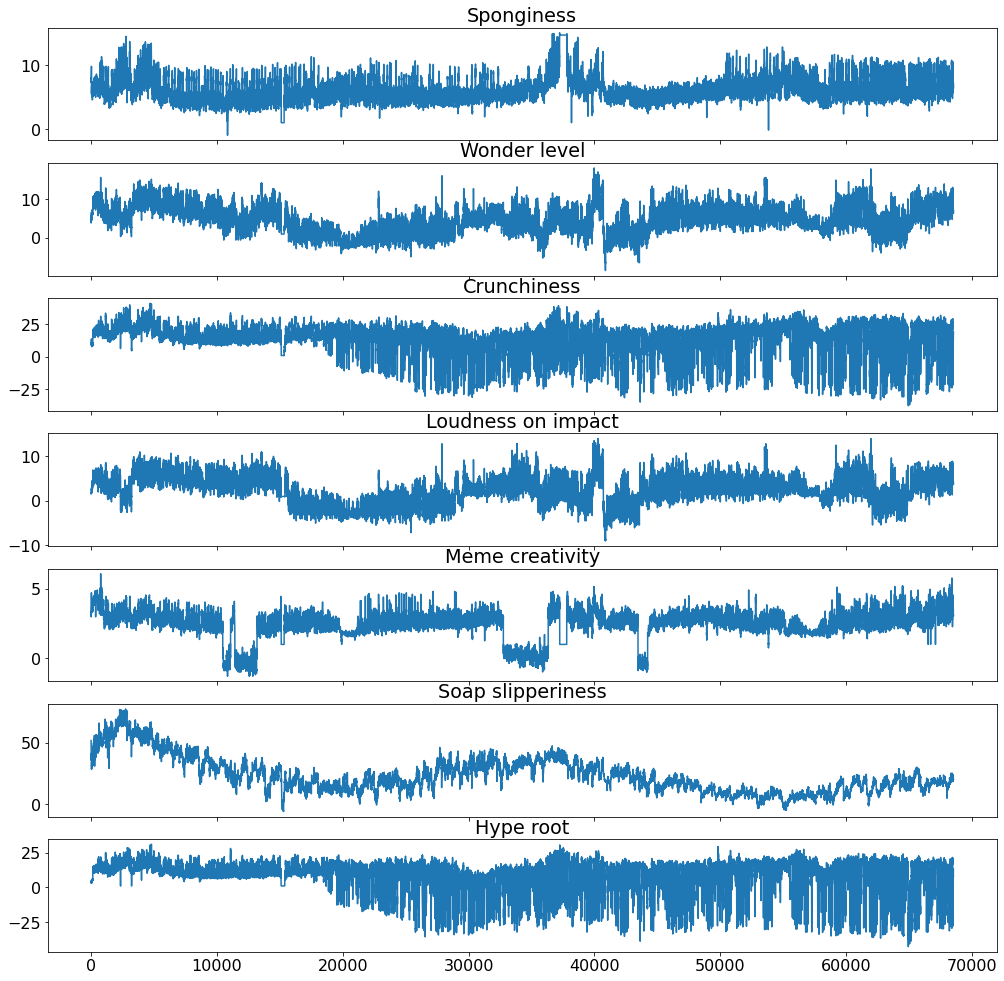

In [5]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

In [6]:
print(dataset.shape)

(68528, 7)


In [7]:
X_min = dataset.min()
X_max = dataset.max()

dataset = (dataset-X_min)/(X_max-X_min)
dataset.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,0.556576,0.481134,0.612986,0.468044,0.613765,0.691885,0.629100
1,0.562874,0.485320,0.611573,0.465453,0.627575,0.690471,0.626693
2,0.559777,0.476949,0.611573,0.462934,0.606973,0.682070,0.626693
3,0.559777,0.476949,0.611573,0.465453,0.606973,0.621844,0.626693
4,0.550279,0.485320,0.610160,0.465453,0.620783,0.637254,0.626693


In [8]:
window = 128
stride = 16
telescope = 864

In [9]:
def build_sequences(df, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df.copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [10]:
X_train, y_train = build_sequences(dataset, window, stride, telescope)
print(X_train.shape, y_train.shape)

(4226, 128, 7) (4226, 864, 7)


In [11]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 100
print(input_shape)
print(output_shape)
print(output_shape[0])
print(output_shape[1])

(128, 7)
(864, 7)
864
7


In [12]:
def build_model():

    telescope = output_shape[0]
    num_channels = output_shape[1]
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # Convolutional part
    cnn = tfkl.Conv1D(8,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(16,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(32,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(64,3,padding='same',activation='relu')(cnn)
    gap = tfkl.Flatten()(cnn)

    # Fully connected part
    dense1 = tfkl.Dense(telescope*num_channels, activation='relu')(gap)
    dense2 = tfkl.Dense(telescope*num_channels, activation='relu')(dense1)
    output_layer = tfkl.Reshape((telescope, num_channels))(dense2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='SimpleForecasting')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', tfk.metrics.RootMeanSquaredError()])

    # Return the model
    return model

2022-01-20 15:08:40.616719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 15:08:40.723746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 15:08:40.724558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 15:08:40.726069: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "SimpleForecasting"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 7)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 8)            176       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 16)            400       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 32)            1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 32)      

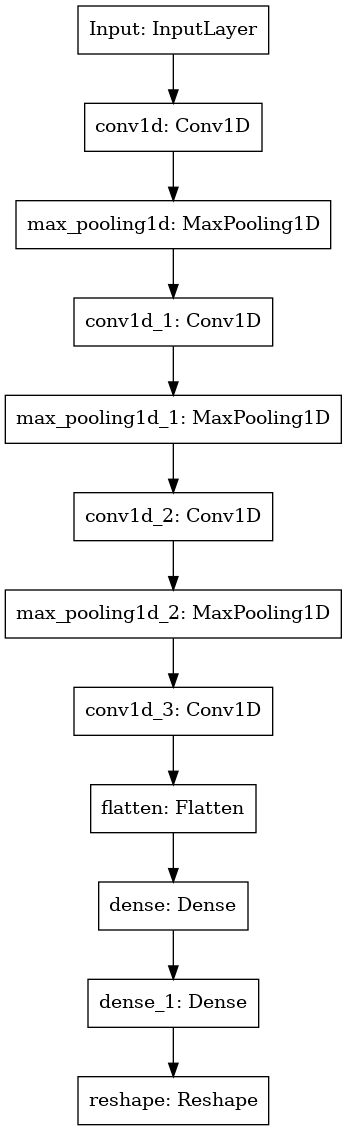

In [13]:
model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [14]:
history = model.fit(
    x = X_train,
    y = y_train,
    validation_split = .1,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

2022-01-20 15:08:44.050317: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-20 15:08:45.588203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


60/60 [==============================] - 8s 15ms/step - loss: 0.1087 - mae: 0.2457 - root_mean_squared_error: 0.3297 - val_loss: 0.0840 - val_mae: 0.2078 - val_root_mean_squared_error: 0.2898
Epoch 2/100
60/60 [==============================] - 1s 10ms/step - loss: 0.0747 - mae: 0.1866 - root_mean_squared_error: 0.2733 - val_loss: 0.0693 - val_mae: 0.1789 - val_root_mean_squared_error: 0.2633
Epoch 3/100
60/60 [==============================] - 1s 10ms/step - loss: 0.0632 - mae: 0.1655 - root_mean_squared_error: 0.2515 - val_loss: 0.0601 - val_mae: 0.1612 - val_root_mean_squared_error: 0.2451
Epoch 4/100
60/60 [==============================] - 1s 10ms/step - loss: 0.0585 - mae: 0.1562 - root_mean_squared_error: 0.2418 - val_loss: 0.0570 - val_mae: 0.1558 - val_root_mean_squared_error: 0.2387
Epoch 5/100
60/60 [==============================] - 1s 10ms/step - loss: 0.0521 - mae: 0.1434 - root_mean_squared_error: 0.2284 - val_loss: 0.0493 - val_mae: 0.1392 - val_root_mean_squared_error:

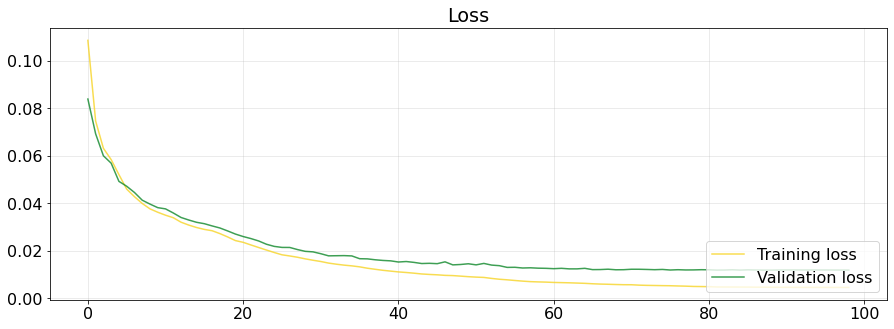

In [15]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#F7D426')
plt.plot(history['val_loss'], label='Validation loss', alpha=.8, color='#0E8729')
plt.title('Loss')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.savefig('Convolutional-graph.png')
plt.show()

In [16]:
model.save('Convolutional')

2022-01-20 15:10:08.172893: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
